## Lab 11: Another linear regression (in finance)
- Objectives:
  - Calculate pairwise correlations between the variables 
  - Multiple linear regression using market data
    - Using statesmodel 
    - Using sklearn

Step 1： Getting data and exploratory analysis 


In [3]:
## Import the required libraries

import numpy as np
import pandas as pd
import yfinance as yf
import datetime
import matplotlib.pyplot as plt

## To use statsmodels for linear regression
import statsmodels.formula.api as smf

## To use sklearn for linear regression
from sklearn.linear_model import LinearRegression

In [4]:
### Fetch data from yfinance 
## 5-year daily data from Coca-Cola, SPY, pepsi and USD index 
end_time = datetime.date(2022,10,21)
start_time = end_time-pd.Timedelta(days = 365*5 ) ## Represents a duration, the difference between two dates or times.
ko_df = yf.download('KO', start = start_time, \
      ened = end_time,progress = False)
spy_df = yf.download('SPY', start = start_time, \
      ened = end_time,progress = False)
pep_df = yf.download('PEP', start = start_time, \
      ened = end_time,progress = False)
usdx_df = yf.download('DX-Y.NYB', start = start_time, \
      ened = end_time,progress = False)

In [5]:
### Calculate log returns 
ko_df['ko'] = np.log(ko_df['Adj Close']/ko_df['Adj Close'].shift(1))
spy_df['spy'] = np.log(spy_df['Adj Close']/spy_df['Adj Close'].shift(1))
pep_df['pep'] = np.log(pep_df['Adj Close']/pep_df['Adj Close'].shift(1))
usdx_df['usdx'] = np.log(usdx_df['Adj Close']/usdx_df['Adj Close'].shift(1))

In [6]:
### create a dataframe with X's and Y 
df = pd.concat([spy_df['spy'], ko_df['ko'], 
                pep_df['pep'], usdx_df['usdx']],axis=1).dropna()
### save the csv file
df.to_csv('regression.csv')

In [7]:
df.describe()

,spy,ko,pep,usdx
count,1258.000000,1258.000000,1258.000000,1258.000000
mean,0.000370,0.000278,0.000465,0.000143
std,0.013360,0.013561,0.013970,0.003994
min,-0.115887,-0.101728,-0.121358,-0.016262
25%,-0.004496,-0.005204,-0.005178,-0.002339
50%,0.000847,0.000739,0.000771,0.000000
75%,0.006757,0.006735,0.006742,0.002457
max,0.086731,0.062783,0.121656,0.016389


In [8]:
df.head()

,spy,ko,pep,usdx
Date,,,,
2017-10-24 00:00:00-04:00,0.001756,-0.003027,-0.008452,0.000213
2017-10-25 00:00:00-04:00,-0.004962,-0.002819,-0.006159,-0.002664
2017-10-26 00:00:00-04:00,0.001292,0.003901,0.005978,0.009558
2017-10-27 00:00:00-04:00,0.008143,-0.003467,-0.001175,0.003271
2017-10-30 00:00:00-04:00,-0.003732,-0.004568,-0.008627,-0.004540


In [9]:
import cufflinks as cf
df.iplot(y=['spy','ko','pep','usdx'],width=2.0,xTitle='Date',yTitle='Log Price')

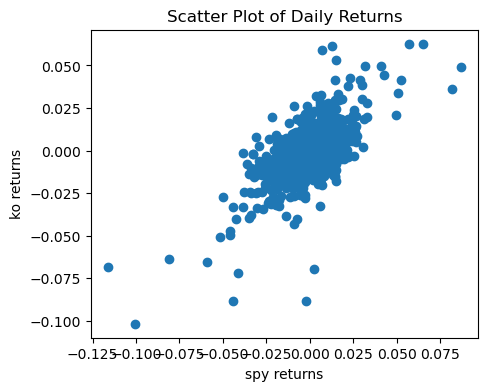

In [11]:
## scatter plot between spy and ko to examine the nature of their relaitonship visually 
plt.figure(figsize=(5,4))
plt.rcParams.update({'font.size':10})
plt.xlabel('spy returns')
plt.ylabel('ko returns')
plt.title('Scatter Plot of Daily Returns')
plt.scatter(df['spy'],df['ko'])
plt.show()

In [16]:
# using cufflinks 
df.iplot(kind='scatter',x='spy',y='ko',mode='markers',\
      xTitle='spy returns',
      yTitle='ko returns', 
      colors="tomato",
      size=6,
      symbol='circle-open-dot',
      bestfit=True,
      bestfit_colors=['pink'],
      title='Scatter plot of returns')

In [17]:
# calculate correlaiton 
df.corr()

,spy,ko,pep,usdx
spy,1.000000,0.644045,0.669603,-0.154883
ko,0.644045,1.000000,0.754394,-0.145645
pep,0.669603,0.754394,1.000000,-0.073679
usdx,-0.154883,-0.145645,-0.073679,1.000000


<AxesSubplot:>

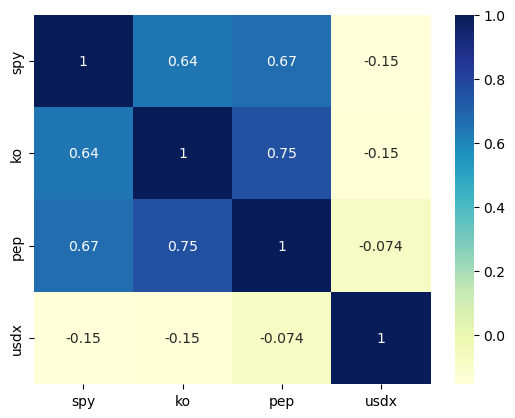

In [20]:
import seaborn as sns 
sns.heatmap(df.corr(), cmap="YlGnBu", annot=True)


----
Step 2: regression using statsmodels 
- Work with the SPY and the KO returns as the explanatory and response variables respectively, while implementing simple linear regression.

In [24]:
### Create an instance of the class OLS
slr_sm_model = smf.ols('ko ~ spy', data=df)

### Fit the model (statsmodels calculates beta_0 and beta_1 here)
slr_sm_model_ko = slr_sm_model.fit()

### Summarize the model

print(slr_sm_model_ko.summary()) 

param_slr = slr_sm_model_ko.params

                            OLS Regression Results                            
Dep. Variable:                     ko   R-squared:                       0.415
Model:                            OLS   Adj. R-squared:                  0.414
Method:                 Least Squares   F-statistic:                     890.3
Date:                Sun, 23 Oct 2022   Prob (F-statistic):          2.59e-148
Time:                        14:12:20   Log-Likelihood:                 3962.6
No. Observations:                1258   AIC:                            -7921.
Df Residuals:                    1256   BIC:                            -7911.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.576e-05      0.000      0.122      0.9

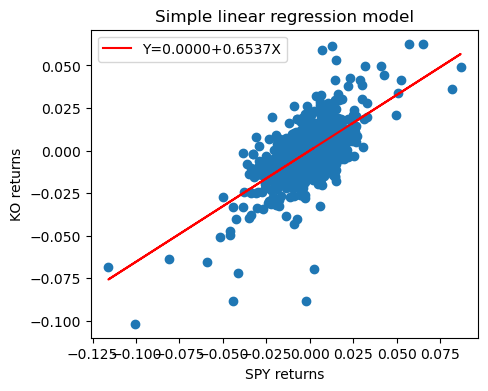

In [26]:
## Linear regression plot of X (spy) and Y (ko)
plt.figure(figsize = (5, 4))
plt.rcParams.update({'font.size': 10})
plt.xlabel("SPY returns")
plt.ylabel("KO returns")
plt.title("Simple linear regression model")
plt.scatter(df['spy'],df['ko'])
plt.plot(df['spy'], param_slr.Intercept+param_slr.spy * df['spy'],
         label='Y={:.4f}+{:.4f}X'.format(param_slr.Intercept, param_slr.spy), 
         color='red')
plt.legend()
plt.show()



- Multiple linear regression 
   - we use SPY, PEP and DX returns as explanatory variables to explain KO returns.

In [27]:
model = smf.ols('ko~spy+pep+usdx',data = df)
model_ko=model.fit()
print(model_ko.summary())


                            OLS Regression Results                            
Dep. Variable:                     ko   R-squared:                       0.608
Model:                            OLS   Adj. R-squared:                  0.607
Method:                 Least Squares   F-statistic:                     648.9
Date:                Sun, 23 Oct 2022   Prob (F-statistic):          1.51e-254
Time:                        14:16:41   Log-Likelihood:                 4215.0
No. Observations:                1258   AIC:                            -8422.
Df Residuals:                    1254   BIC:                            -8401.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -4.652e-05      0.000     -0.194      0.8

----
Step 3: regression using scikit-learn
- We can also use the scikit-learn library for regressional analysis. However, it is geared to meet slightly different needs. The focus here is on the prediction/forecast of unobserved values.
- Unlike statsmodels, here, we don't have the option of a full summary table with a detailed output.
- Notice also how the features and output specified are done so in the .fit() routine (with features first and then the output variable). In statsmodels, we specified the parameters (in reverse order) when we instantiated the OLS class.


In [31]:
### Create an instance of the class LinearRegression()
slr_skl_model = LinearRegression()

### Fit the model (sklearn calculates beta_0 and beta_1 here)

X = df['spy'].values.reshape(-1, 1)
slr_skl_model_ko = slr_skl_model.fit(X, df['ko'])
print("The intercept in the sklearn regression result is", \
      np.round(slr_skl_model_ko.intercept_, 4))
print("The slope in the sklearn regression model is", \
      np.round(slr_skl_model_ko.coef_[0], 4))

The intercept in the sklearn regression result is 0.0
The slope in the sklearn regression model is 0.6537


In [32]:
mlr_skl_model=LinearRegression()
X=df[['spy','pep','usdx']]
y=df['ko']
mlr_skl_model_ko=mlr_skl_model.fit(X,y)
print("The intercept in the sklearn regression result is", \
      mlr_skl_model_ko.intercept_)
print("The slope in the sklearn regression model is", \
      mlr_skl_model_ko.coef_)

The intercept in the sklearn regression result is -4.652143759369912e-05
The slope in the sklearn regression model is [ 0.2429343   0.57208826 -0.22124758]
